In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import geopandas

%matplotlib inline

##  The Novel Coronavirus: Data Science and Machine Learning Visualizations

This is the site where I pull the recent `.csv` files: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

Formats of the `.csv` files are bound to change and they're manually pulled from the website.

Also trying to find ways to automatically pull the dataset, if possible

In [2]:
!ls

COVID19 Visualizations.ipynb README.md
COVID19_databases            cases_country
COVID19_worldwide.png        cases_country_active
COVID19_worldwide_active.png cases_country_individual
LICENSE                      geo


Load the CSV files. Please make sure to pull the latest files from the website. Using the confirmed, deaths, and recovered databases.

Directories and archives as well will be stored in COVID19_databases/ (As of April 2nd)

In [3]:
COVID19_confirmed = pd.read_csv("COVID19_databases/time_series_covid19_confirmed_global.csv")
COVID19_deaths = pd.read_csv("COVID19_databases/time_series_covid19_deaths_global.csv")
COVID19_recovered = pd.read_csv("COVID19_databases/time_series_covid19_recovered_global.csv")

#Global variables
databases = [COVID19_confirmed, COVID19_deaths, COVID19_recovered]
dataset = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]

all_countries = list(COVID19_confirmed['Country/Region'])
all_countries = list(dict.fromkeys(all_countries))

dates = list(COVID19_confirmed.columns)
dates.remove('Country/Region')
dates.remove('Province/State')
dates.remove('Lat')
dates.remove('Long')

In [4]:
def data_clean(data):
    data = data.drop(['Province/State', 'Lat', 'Long'], axis=1)
    data = data.groupby(['Country/Region'])[dates].sum()
    data.columns = pd.to_datetime(data.columns)
    return data

In [5]:
COVID19_confirmed = data_clean(COVID19_confirmed)
COVID19_deaths = data_clean(COVID19_deaths)
COVID19_recovered = data_clean(COVID19_recovered)
dataset = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]

In [6]:
COVID19_confirmed.head(20)

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
Albania,0,0,0,0,0,0,0,0,0,0,...,663,678,712,726,736,750,766,773,782,789
Algeria,0,0,0,0,0,0,0,0,0,0,...,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
Andorra,0,0,0,0,0,0,0,0,0,0,...,723,731,738,738,743,743,743,745,745,747
Angola,0,0,0,0,0,0,0,0,0,0,...,25,25,25,26,27,27,27,27,30,35
Antigua and Barbuda,0,0,0,0,0,0,0,0,0,0,...,24,24,24,24,24,24,24,24,25,25
Argentina,0,0,0,0,0,0,0,0,0,0,...,3435,3607,3780,3892,4003,4127,4285,4428,4532,4681
Armenia,0,0,0,0,0,0,0,0,0,0,...,1523,1596,1677,1746,1808,1867,1932,2066,2148,2273
Australia,0,0,0,0,4,5,5,6,9,9,...,6662,6677,6694,6714,6721,6744,6752,6766,6778,6799


In [7]:
def cases_country(country_name, data, label=None):
    country_plot = data.loc[country_name]
    country_plot = country_plot.sort_index().plot(label=label)
    
    if data.equals(COVID19_confirmed):
        data_label = "Confirmed Cases"
    elif data.equals(COVID19_recovered):
        data_label = "Recovered"
    else:
        data_label = "Deaths"
    
    #Labelings
    country_plot.set_ylabel("Number of " + data_label)
    country_plot.set_xlabel("Day")
    country_plot.set_title(data_label + " in " + country_name)
    return country_plot

def update_all_cases_country_individual():
    for country in all_countries:
        for data in dataset:
            cases_country(country, data[0])
            plt.savefig("cases_country_individual/" + country + "_" + data[1] + ".png")
            plt.tight_layout()
            plt.clf()
            
def all_cases_country(country_name):
    for data in dataset:
        plt = cases_country(country_name, data[0], label=data[1])
    
    #Labelings
    plt.set_ylabel("Number of Cases")
    plt.set_xlabel("Day")
    plt.set_title("COVID-19 in " + country_name)
    plt.legend()
    return plt

def update_all_cases_country():
    for country in all_countries:
        all_cases_country(country)
        plt.savefig("cases_country/" + country + "_all.png")
        plt.tight_layout()
        plt.clf()
        
def worldwide_cases():
    world = COVID19_confirmed.sum().plot(label="confirmed")
    world = COVID19_deaths.sum().plot(label="deaths")
    world = COVID19_recovered.sum().plot(label="recovered")

    #Labelings
    world.set_ylabel("Number of Cases")
    world.set_xlabel("Day")
    world.set_title("COVID-19 Worldwide")
    world.legend()
    plt.savefig("COVID19_worldwide")
    return world

def cases_country_active(country_name):
    """
    active = confirmed - deaths - recovered
    """
    confirmed = COVID19_confirmed.loc[country_name]
    deaths = COVID19_deaths.loc[country_name]
    recovered = COVID19_recovered.loc[country_name]
    
    active = confirmed - deaths - recovered

    active = active.plot()
    active.set_ylabel("Number of Active Cases")
    active.set_xlabel("Day")
    active.set_title("Active COVID-19 Cases in " + country_name)
    
def update_all_cases_country_active():    
    for country in all_countries:
        cases_country_active(country)
        plt.savefig("cases_country_active/" + country + "_active_cases.png")
        plt.tight_layout()
        plt.clf()
        
def worldwide_active():
    confirmed = COVID19_confirmed.sum()
    deaths = COVID19_deaths.sum()
    recovered = COVID19_recovered.sum()
    
    active = confirmed - deaths - recovered
    active = active.plot()

    #Labelings
    active.set_ylabel("Number of Active Cases")
    active.set_xlabel("Day")
    active.set_title("COVID-19 Active Cases Worldwide")
    
    plt.savefig("COVID19_worldwide_active.png")
    return active

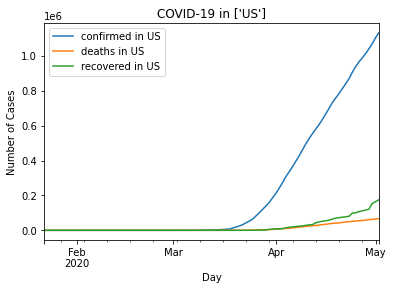

In [8]:
def compare_countries(list_countries):    
    for country in list_countries:
        for data in dataset:
            country_data = data[0]
            country_data = country_data.loc[country]
            country_data = country_data.plot(label=data[1] + " in " + str(country))

    country_data.set_ylabel("Number of Cases")
    country_data.set_xlabel("Day")
    country_data.set_title("COVID-19 in " + str(list(list_countries)))
    country_data.legend()
    
    #plt.savefig(str(list_countries) + ".png")
    
compare_countries(['US'])

In [9]:
update_all_cases_country_individual()

<Figure size 432x288 with 0 Axes>

In [10]:
update_all_cases_country()

<Figure size 432x288 with 0 Axes>

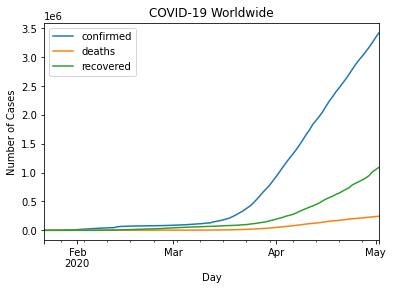

In [11]:
worldwide_cases()

In [12]:
update_all_cases_country_active()

<Figure size 432x288 with 0 Axes>

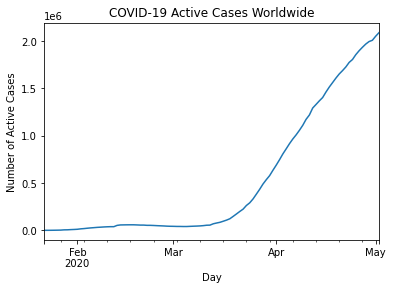

In [13]:
worldwide_active()

In [14]:
pd.set_option('max_rows', None)
#pd.reset_option("max_rows")

# Visualizations with GeoPandas

https://geopandas.org/mapping.html

Also attempted to implement the GeoPlot library along with GeoPandas, but it won't install properly.
https://geopandas.org/gallery/plotting_with_geoplot.html

In [15]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

In [16]:
COVID19_geo_confirmed = dataset[0][0]
COVID19_geo_deaths = dataset[1][0]
COVID19_geo_recovered = dataset[2][0]

COVID19_geo_confirmed.reset_index(level=0, inplace=True)
COVID19_geo_deaths.reset_index(level=0, inplace=True)
COVID19_geo_recovered.reset_index(level=0, inplace=True)

COVID19_geo_confirmed = COVID19_geo_confirmed.rename(columns={"Country/Region" : "name"})
COVID19_geo_deaths = COVID19_geo_deaths.rename(columns={"Country/Region" : "name"})
COVID19_geo_recovered = COVID19_geo_recovered.rename(columns={"Country/Region" : "name"})

COVID19_geo_confirmed = COVID19_geo_confirmed.replace({'Taiwan*': 'Taiwan', 'Korea, South': 'South Korea', 'US' : 'United States of America'})
COVID19_geo_deaths = COVID19_geo_deaths.replace({'Taiwan*': 'Taiwan', 'Korea, South': 'South Korea', 'US' : 'United States of America'})
COVID19_geo_recovered = COVID19_geo_recovered.replace({'Taiwan*': 'Taiwan', 'Korea, South': 'South Korea', 'US' : 'United States of America'})

#Delete any islands and Antartica
world_confirmed = world.merge(COVID19_geo_confirmed, how = 'inner', on = 'name')
world_confirmed = world_confirmed[(world_confirmed.pop_est>0) & (world_confirmed.name!="Antarctica")]

world_deaths = world.merge(COVID19_geo_deaths, how = 'inner', on = 'name')
world_deaths = world_deaths[(world_deaths.pop_est>0) & (world_deaths.name!="Antarctica")]

world_recovered = world.merge(COVID19_geo_recovered, how = 'inner', on = 'name')
world_recovered = world_recovered[(world_recovered.pop_est>0) & (world_recovered.name!="Antarctica")]

In [17]:
dates = list(COVID19_geo_confirmed)
dates.remove('name')
dates.sort()

In [18]:
pd.set_option('max_rows', None)
#world_confirmed.head(150)

In [19]:
def geo_confirmed_corona(data):    
    for i in range(len(dates)):
        fig, ax = plt.subplots(1, 1)

        world_confirmed.plot(column=dates[i],
                   cmap='Reds',
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': "Population by Country",
                                'orientation': "horizontal"})

        #Save the figure
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20, 10)
        fig.savefig('geo/geo_confirmed/' + str(i).zfill(3) + '.png', dpi=100)
        plt.close(fig)
        
def geo_deaths_corona(data):
    for i in range(len(dates)):
        fig, ax = plt.subplots(1, 1)

        world_deaths.plot(column=dates[i],
                   cmap='Greys',
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': "Population by Country",'orientation': "horizontal"})

        #Save the figure
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20, 10)
        fig.savefig('geo/geo_deaths/' + str(i).zfill(3) + '.png', dpi=100)
        plt.close(fig)
        
def geo_recovered_corona(data):
    for i in range(len(dates)):
        fig, ax = plt.subplots(1, 1)

        world_recovered.plot(column=dates[i],
                   cmap='Greens',
                   ax=ax,
                   legend=True,
                   legend_kwds={'label': "Population by Country",'orientation': "horizontal"})

        #Save the figure
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(20, 10)
        fig.savefig('geo/geo_recovered/' + str(i).zfill(3) + '.png', dpi=100)
        plt.close(fig)
        
geo_confirmed_corona(COVID19_geo_confirmed)
geo_deaths_corona(COVID19_geo_deaths)
geo_recovered_corona(COVID19_geo_recovered)

In [20]:
def compile_timelapse():
    !rm geo/geo_confirmed/confirmed_timelapse.mp4
    !rm geo/geo_deaths/deaths_timelapse.mp4
    !rm geo/geo_recovered/recovered_timelapse.mp4
    
    !rm geo/geo_confirmed/confirmed_timelapse.gif
    !rm geo/geo_deaths/deaths_timelapse.gif
    !rm geo/geo_recovered/recovered_timelapse.gif
    
    !ffmpeg -r 2 -i geo/geo_confirmed/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p geo/geo_confirmed/confirmed_timelapse.mp4
    !ffmpeg -r 2 -i geo/geo_deaths/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p geo/geo_deaths/deaths_timelapse.mp4
    !ffmpeg -r 2 -i geo/geo_recovered/%03d.png -c:v libx264 -r 30 -pix_fmt yuv420p geo/geo_recovered/recovered_timelapse.mp4

    !ffmpeg -i geo/geo_confirmed/%03d.png geo/geo_confirmed/confirmed_timelapse.gif
    !ffmpeg -i geo/geo_deaths/%03d.png geo/geo_deaths/deaths_timelapse.gif
    !ffmpeg -i geo/geo_recovered/%03d.png geo/geo_recovered/recovered_timelapse.gif
    
compile_timelapse()

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.2_2 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat   

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.2_2 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-libsoxr --enable-videotoolbox --disable-libjack --disable-indev=jack
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat   

Output #0, gif, to 'geo/geo_deaths/deaths_timelapse.gif':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0: Video: gif, bgr8, 2000x1000 [SAR 1:1 DAR 2:1], q=2-31, 200 kb/s, 25 fps, 100 tbn, 25 tbc
    Metadata:
      encoder         : Lavc58.54.100 gif
frame=  102 fps= 26 q=-0.0 Lsize=    2349kB time=00:00:04.05 bitrate=4750.9kbits/s speed=1.05x    
video:2349kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000832%
ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.2.2_2 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-lib